In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from forex_env import ForexTradingEnv
import yfinance as yf

from IPython.display import clear_output

In [2]:
# Obtain data from the Yahoo! finance API
start_date = '2017-01-01' 
end_date = '2022-01-01' 
df = yf.download('USDJPY=X', start_date, end_date)

# Process to match the environment's expected 'ohlc' format
df = df.rename(columns=str.lower).drop(['adj close', 'volume'], axis=1)
df.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close
Date,,,,
2017-01-02,116.809998,117.485001,116.724998,116.794998
2017-01-03,117.487999,118.593002,117.286003,117.495003
2017-01-04,117.678001,118.176003,117.068001,117.658997
2017-01-05,117.056000,117.084999,115.292999,117.112999
2017-01-06,115.318001,116.744003,115.263000,115.264999


In [3]:
# Define arguments to the environment constructors
action_space_type = 'percentage'
df_type = 'ohlc'
initial_jpy_amount = 10000000
window_size = 10
end = len(df)
split = int(end * 0.85)

train_env_maker = lambda: ForexTradingEnv(df=df, action_space_type=action_space_type, df_type=df_type, 
                                          initial_jpy_amount=initial_jpy_amount, window_size=window_size, 
                                          frame_bound=(window_size, split))
test_env_maker = lambda: ForexTradingEnv(df=df, action_space_type=action_space_type, df_type=df_type,
                                         initial_jpy_amount=initial_jpy_amount, window_size=window_size, 
                                         frame_bound=(split, end))

In [4]:
# Train the model
train_env = DummyVecEnv([train_env_maker])

timesteps = 200000
model = PPO('MlpPolicy', train_env, verbose=0)
model.learn(timesteps)

In [5]:
# Test the trained model
test_env = test_env_maker()
results = []

for i in range (1, 100):

    obs = test_env.reset()
    profit = 0

    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = test_env.step(action[0])
        profit += rewards
        if done:
            results.append(profit)
            break
            
print(f'Average total profit of 100 runs: {np.mean(results):.2f}')

Average total profit of 100 runs: 368646.78


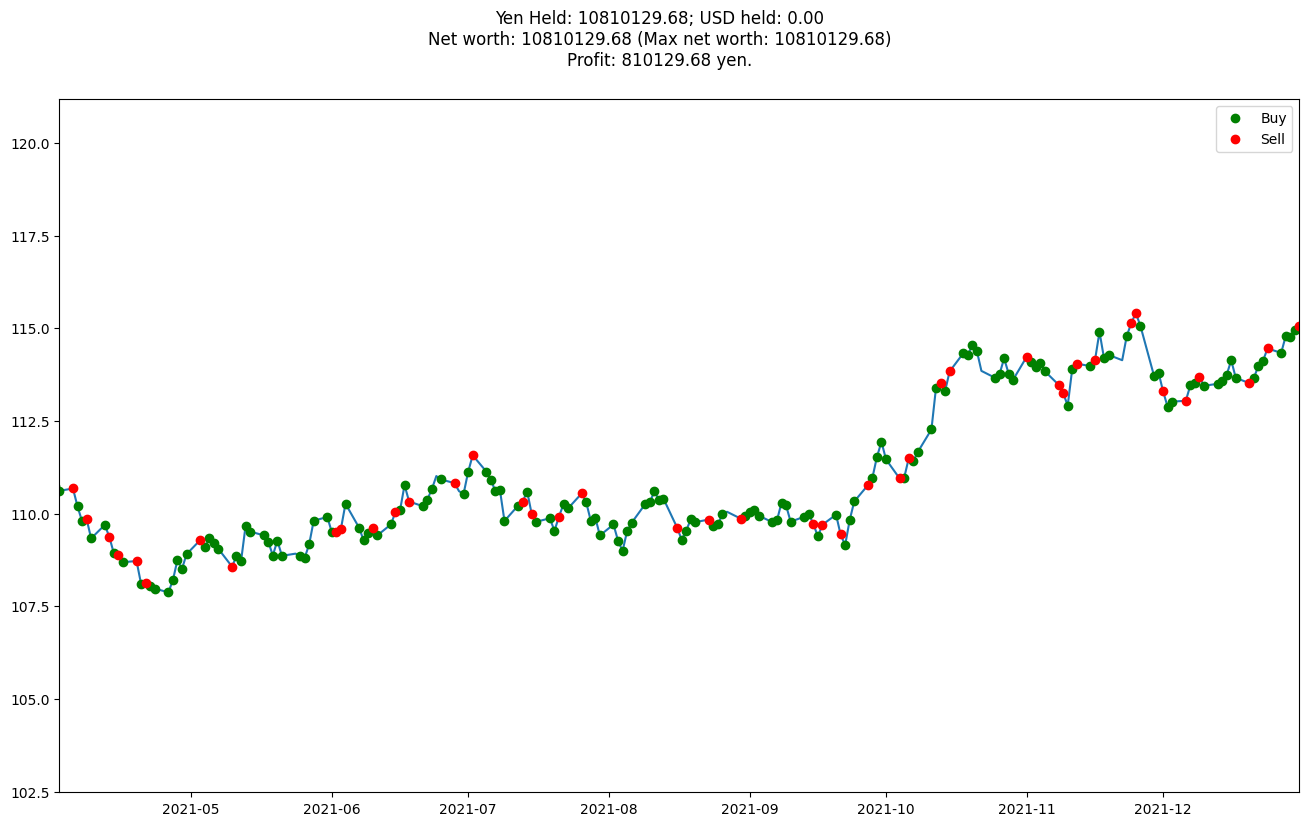

In [6]:
# Final run visualized with a live chart
            
obs = test_env.reset()
profit = 0

while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = test_env.step(action[0])
    clear_output(wait=True)
    test_env.render()
    if done:
        break